In [1]:
import pandas as pd
import numpy as np

In [2]:
comments = pd.read_csv('../data/comments_lang.csv')
comments_en = comments[comments.lang == 'en']

In [6]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [3]:
total = pd.read_csv('label_prop_neg.csv')

In [4]:
from sklearn.neural_network import BernoulliRBM

In [14]:
vect = CountVectorizer(ngram_range = (1,3), stop_words = 'english', min_df = 5, max_df = 0.95).fit(total.Review)

In [15]:
feats = vect.transform(total.Review)

In [16]:
feats.shape

(4251, 1946)

In [17]:
rbm = BernoulliRBM(n_components = 512)
rbm = rbm.fit(feats)

In [18]:
rbm_feats = rbm.transform(feats)

In [24]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoLarsCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [35]:
X_train, X_test, y_train, y_test = train_test_split(rbm_feats, total.label_p, test_size=0.2)

In [36]:
total.label_p.value_counts()

0    2067
2    1480
4     489
3     136
1      79
Name: label_p, dtype: int64

In [37]:
def eval_model(y_train,y_test,y_train_pred,y_test_pred):
    
    class_names = ['unknown',
        'Crash',
        'Balance problems',
        'Synchronization',
        #'Positive',
        'Bug']
    
    class_names_b = ['neg', 'pos']
    print('train scores\n')
    print(classification_report(y_train, y_train_pred, target_names = class_names))
    print('test scores\n')
    print(classification_report(y_test, y_test_pred, target_names = class_names))

In [51]:
m = OneVsRestClassifier(LassoLarsCV()).fit(X_train, y_train)
y_train_pred = m.predict(X_train)
y_test_pred = m.predict(X_test)
eval_model(y_train,y_test,y_train_pred,y_test_pred)

train scores

                  precision    recall  f1-score   support

         unknown       0.72      0.79      0.76      1656
           Crash       0.00      0.00      0.00        60
Balance problems       0.62      0.71      0.66      1182
 Synchronization       0.00      0.00      0.00       111
             Bug       0.68      0.38      0.49       391

     avg / total       0.64      0.68      0.65      3400

test scores

                  precision    recall  f1-score   support

         unknown       0.70      0.74      0.72       411
           Crash       0.00      0.00      0.00        19
Balance problems       0.58      0.70      0.63       298
 Synchronization       0.00      0.00      0.00        25
             Bug       0.65      0.36      0.46        98

     avg / total       0.62      0.65      0.62       851



/home/lsm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components = 5).fit(rbm_feats)

In [21]:
y = pca.transform(rbm_feats)

<IPython.core.display.Javascript object>


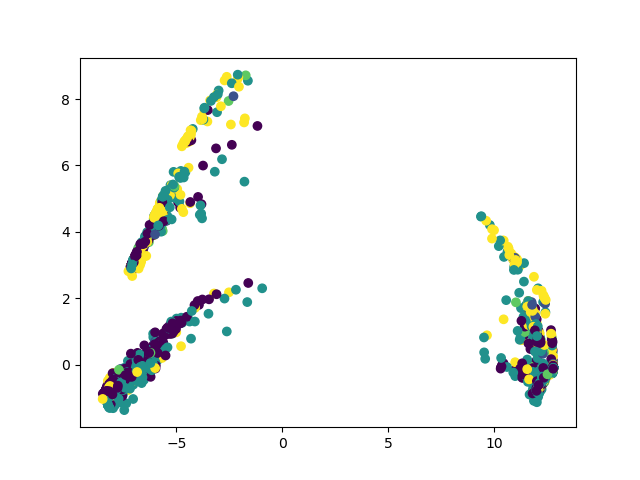

In [56]:
%matplotlib notebook
import matplotlib.pyplot as plt
colors = [int(i % 23) for i in total.label_p]
plt.scatter(y[:,0], y[:,1],c = colors)

In [41]:
comments_en.loc[:,'y0'] = y[:,0]

/Users/dns/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
comments_en[comments_en.y0>0].Review.to_csv('rbm_pos.csv')
comments_en[comments_en.y0<0].Review.to_csv('rbm_neg.csv')